## CST 383: Intro to Data Science
# Project 2 

# Predicting Kickstarter Campaign Success
## Authors: Brianna Magallon, Tyler Pruitt, Rafael Reis

# Introduction: 
#### In this project, we use the Kickstarter Projects dataset to predict whether a campaign will be successful or not. The dataset includes campaign data like goal amount, category, duration, and currency. Our goal is to predict campaign success using classification models. 
### Dataset URL: https://www.kaggle.com/datasets/kemical/kickstarter-projects

In [2]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# plotting
sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = 5,3

## Read the data

In [7]:
df = pd.read_csv("ks-projects-201612.csv", low_memory = False)
#df = pd.read_csv("ks-projects-201612.csv", encoding="cp1252", low_memory=False) # to make encoding work, at elast on macOS

In [8]:
#remove trailing spaces
df.columns = df.columns.str.strip()

In [11]:
df.sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
149339,1887280959,Ultimus Veneficus (Last of the Sorcerers) at t...,Theater,Theater,USD,2010-10-20 06:00:00,2000,2010-09-12 16:51:49,65,failed,2,US,65,NaN,NaN,NaN,NaN
181453,2080857761,Iconic New Orleans Fine Art Prints,Illustration,Art,USD,2013-05-08 21:20:21,300,2013-04-08 21:20:21,945,successful,8,US,945,NaN,NaN,NaN,NaN
92033,1547208305,Feeding Frenzy EP,Country & Folk,Music,USD,2014-06-03 01:03:43,3000,2014-05-14 01:03:43,3632,successful,81,US,3632,NaN,NaN,NaN,NaN
186513,2110439764,Fiz'ikz Clothingô,Apparel,Fashion,USD,2016-08-30 19:41:08,15000,2016-07-01 19:41:08,0,failed,0,US,0,NaN,NaN,NaN,NaN
102926,1611363578,Live Give & Love,Poetry,Publishing,USD,2012-06-02 03:18:41,10000,2012-05-03 03:18:41,0,failed,0,US,0,NaN,NaN,NaN,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             323750 non-null  int64  
 1   name           323746 non-null  object 
 2   category       323745 non-null  object 
 3   main_category  323750 non-null  object 
 4   currency       323750 non-null  object 
 5   deadline       323750 non-null  object 
 6   goal           323750 non-null  object 
 7   launched       323750 non-null  object 
 8   pledged        323750 non-null  object 
 9   state          323750 non-null  object 
 10  backers        323750 non-null  object 
 11  country        323750 non-null  object 
 12  usd pledged    319960 non-null  object 
 13  Unnamed: 13    625 non-null     object 
 14  Unnamed: 14    12 non-null      object 
 15  Unnamed: 15    4 non-null       object 
 16  Unnamed: 16    1 non-null       float64
dtypes: float64(1), int64(1), obje

## Data Exploration

#### In this section, we want to explore key aspects of the kickstarter data, including campaign outcomes, category distribution, and common funding goals. This will help us understand potential predictors of success. 

A look at the columns.

In [18]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16'],
      dtype='object')

In [20]:
df[df['state'] == "canceled"].head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
7,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29 18:14:43,125000,2014-04-24 18:14:43,8233,canceled,58,US,8233,NaN,NaN,NaN,NaN
8,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10 21:55:48,65000,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,NaN,NaN,NaN,NaN
59,1000256760,"Raise the Woof, expanding the love (Canceled)",Design,Design,CAD,2015-08-07 21:46:53,15000,2015-07-08 21:46:53,700,canceled,6,CA,553.324254,NaN,NaN,NaN,NaN
61,1000260691,Gizbeeô Unlimited Removable Storage for Your T...,Gadgets,Technology,USD,2016-03-25 19:30:27,87000,2016-02-29 20:30:27,2030,canceled,15,US,2030,NaN,NaN,NaN,NaN


In [22]:
dftest = df[df['country'] == 'US']
dftest = dftest.drop(columns=["Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16"])

In [24]:
dftest['category'].value_counts()

category
Product Design    13410
Documentary       12864
Music             10288
Shorts            10009
Food               9013
                  ...  
Weaving              45
Residencies          34
Letterpress          28
Chiptune             23
Taxidermy             6
Name: count, Length: 158, dtype: int64

In [26]:
dftest['main_category'].value_counts()

main_category
Film & Video    48086
Music           39517
Publishing      27973
Games           20392
Art             19640
Design          18106
Technology      17913
Food            17479
Fashion         13943
Theater          8138
Comics           7392
Photography      7389
Crafts           5570
Journalism       3092
Dance            2935
Name: count, dtype: int64

We want to see the different outcomes the campaigns had, and which ones will be most relevant for our predictions. 

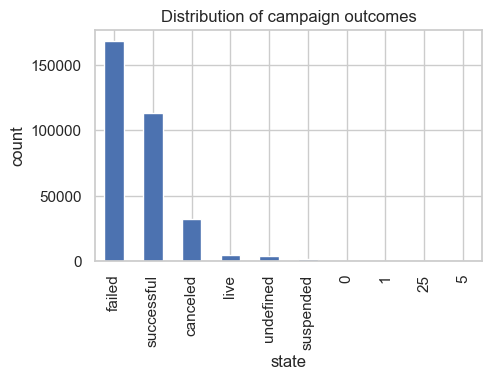

In [29]:
state_counts = df['state'].value_counts().head(10)
state_counts.plot.bar()
plt.title('Distribution of campaign outcomes')
plt.xlabel('state')
plt.ylabel('count')
plt.show()

Here we are able to see that "Failed" and "Successful" are the most common. Most campaings fail and there is an imbalance. 

Here is the exact number in each of these states.

In [33]:
df['state'].value_counts()

state
failed        168221
successful    113081
canceled       32354
live            4428
undefined       3555
               ...  
2312               1
320                1
477                1
1404               1
2634               1
Name: count, Length: 410, dtype: int64

We want to see how Kickstarter campaigns are distributed across different project categories. This will help us understand which categories are most popular and whether there is an imbalance. 

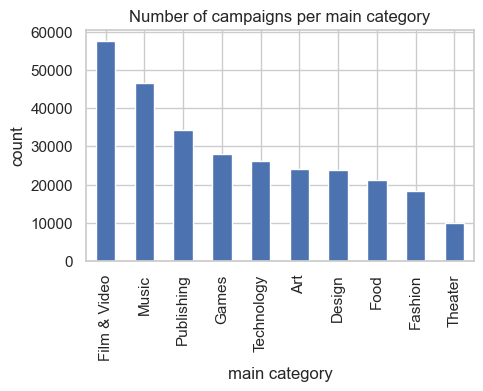

In [36]:
df['main_category'].value_counts().head(10).plot.bar()
plt.title("Number of campaigns per main category")
plt.xlabel("main category")
plt.ylabel("count")
plt.show()

This plot shows us that Film & Video, Music, Publishing are the three most popular Kickstarter categories, while Food, Fashion and Theater are the three least common. 

Let’s explore which goal values appear most often. This will help us identify any odd entries or common default values.

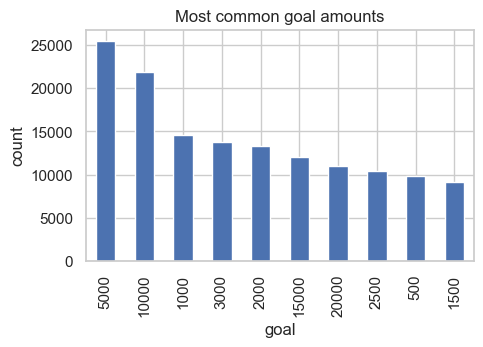

In [40]:
df['goal'].value_counts().head(10).plot.bar()
plt.title("Most common goal amounts")
plt.xlabel("goal")
plt.ylabel("count")
plt.show()

We are able to see that the most common goal amounts are round numbers like 5000, 1000, and 10000.

## Preprocessing /Data Cleaning

#### Before applying any machine learning models, we need to clean and prepare the data. 

Here we are removing irrelevant columns that contain no useful information. 

In [46]:
df = df.drop(columns=["Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16"])

In [48]:
df[df.isnull().any(axis=1)].sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
110919,1658549179,Recording Paige Conroy's Original Music,Music,Music,USD,2016-04-16 02:00:00,2650,2016-03-21 23:44:07,5219,undefined,0,"N,""0",NaN
307574,902712379,Album of Fun Songs You Can Help Me Make If You...,Music,Music,USD,2016-04-06 15:55:43,1800,2016-03-07 15:55:43,2338.61,undefined,0,"N,""0",NaN
110137,1653767643,Hot Club of Flatbush New Recording,Music,Music,USD,2015-10-06 21:52:26,4000,2015-09-06 21:52:26,4115,undefined,0,"N,""0",NaN
181607,208180997,"Mimika's new album, a Retro Futuristic Space-J...",Music,Music,GBP,2015-03-26 14:06:14,2000,2015-02-24 15:06:14,2037,undefined,0,"N,""0",NaN
265406,649815840,Mikel Wright & The Wrongs - Album #2.0,Music,Music,USD,2015-03-11 06:43:33,2000,2015-01-25 07:43:33,2050,undefined,0,"N,""0",NaN


Keep only rows where 'state' is one of the target outcomes

In [51]:
df = df[df['state'].isin(["successful", "failed", "canceled"])]

In [53]:
print("Rows still with null values: ", len(df[df.isnull().any(axis=1)]))
df[df.isnull().any(axis=1)].sample(5)

Rows still with null values:  235


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
261862,628318669,Meekoh // Fire and Diamonds,Music,Music,USD,2016-05-18 06:00:00,4000,2016-05-03 02:43:13,4161,successful,0,"N,""0",NaN
212959,335528748,Beyond Tha Means,Publishing,Publishing,USD,2016-04-24 12:12:28,3500,2016-04-20 12:12:28,0,failed,0,"N,""0",NaN
255091,587878217,Airport32,Apparel,Fashion,EUR,2016-04-30 14:02:00,31500,2016-03-16 18:49:04,229.5,failed,0,"N,""0",NaN
241282,504472892,"Thea Picard's Debut EP, Jazzy Soulful Pop Good...",Music,Music,USD,2016-05-04 20:12:00,6500,2016-04-06 05:49:50,6645,successful,0,"N,""0",NaN
103781,1616493243,Taking my e-commerce website to the next level,Music,Music,USD,2016-04-28 02:33:44,2500,2016-04-03 02:33:44,47.13,failed,0,"N,""0",NaN


It seems the vast majority of Kickstarter campaigns with null values fall under the Music and Film categories, often with zero backers. The campaign states vary, which likely reflects that creating music or films isn’t strongly tied to financial backing (there’s probably a joke in there somewhere).

Since these projects lack key information like backer count or country and only account for 127 rows, we’ll remove them from the dataset.

In [56]:
df = df.dropna()
len(df[df.isnull().any(axis=1)]) # checking
df.info() # Current state

<class 'pandas.core.frame.DataFrame'>
Index: 313421 entries, 0 to 323749
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ID             313421 non-null  int64 
 1   name           313421 non-null  object
 2   category       313421 non-null  object
 3   main_category  313421 non-null  object
 4   currency       313421 non-null  object
 5   deadline       313421 non-null  object
 6   goal           313421 non-null  object
 7   launched       313421 non-null  object
 8   pledged        313421 non-null  object
 9   state          313421 non-null  object
 10  backers        313421 non-null  object
 11  country        313421 non-null  object
 12  usd pledged    313421 non-null  object
dtypes: int64(1), object(12)
memory usage: 33.5+ MB


Convert 'goal' column to numeric, remove any rows where conversion fails

In [59]:
df['goal'] = pd.to_numeric(df['goal'], errors='coerce').astype(int)
df.dropna(subset=['goal'], inplace=True)
print(df['goal'])

0          1000
1         45000
2          5000
3         19500
4         50000
          ...  
323745    50000
323746     1500
323747    15000
323748    15000
323749     2000
Name: goal, Length: 313421, dtype: int64


Keep only US campaigns

In [62]:
#Dropping all rows outside the US
df = df[df['country'] == 'US']